In [89]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

In [90]:
import torch
mps_available = torch.backends.mps.is_available()
print("MPS available:", mps_available)


MPS available: True


In [91]:
# Setting size parameters of images
im_width = 256
im_height = 256

## Loading the image and mask paths


In [92]:
image_filename_train = []

# creating a list of all files containing the word 'mask'
mask_files = glob('../../Dataset/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filename_train.append(i.replace('_mask', ''))

print(image_filename_train[:10])
len(image_filename_train)

['../../Dataset/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8.tif', '../../Dataset/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_9.tif', '../../Dataset/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_2.tif', '../../Dataset/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_3.tif', '../../Dataset/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_20.tif', '../../Dataset/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_15.tif', '../../Dataset/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_14.tif', '../../Dataset/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_18.tif', '../../Dataset/Brain MRI Se

3929

## Plotting few images and masks

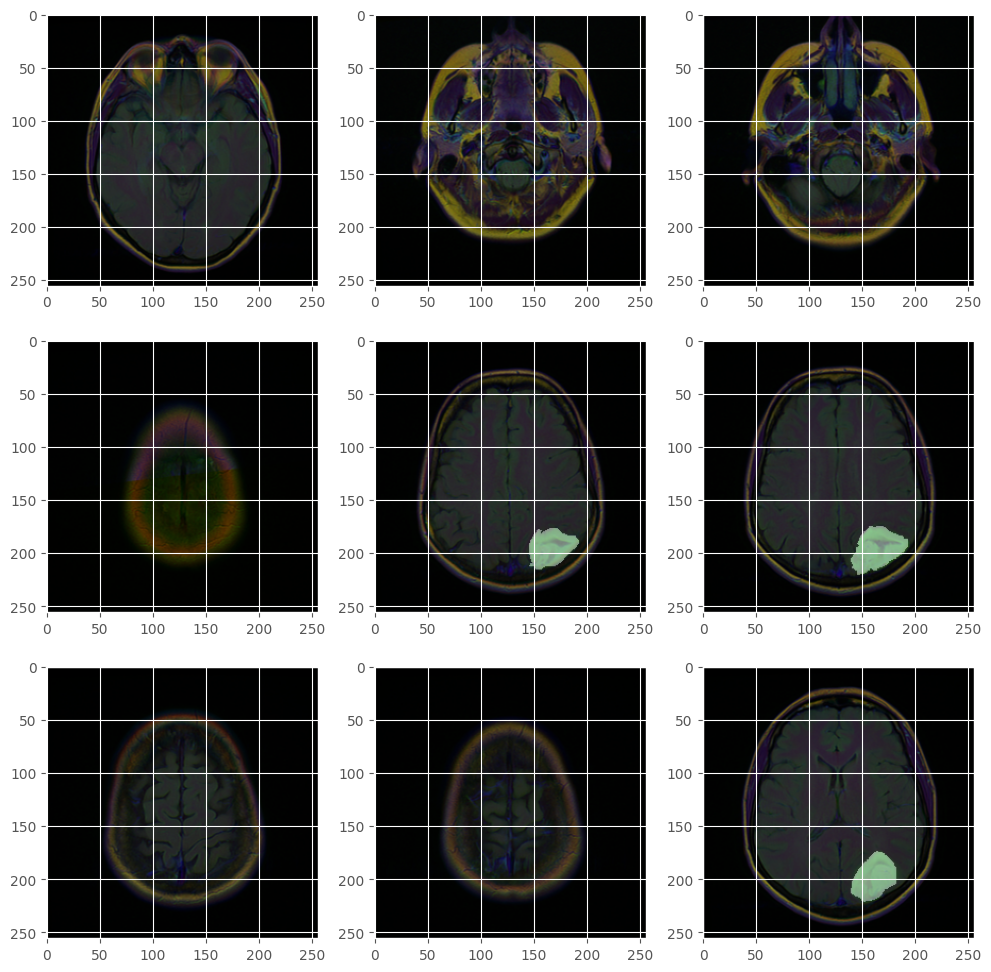

In [93]:
plot_from_img_path(3,3,image_filename_train, mask_files)

## Create data Frame and split data on train set, validation set and test set

In [94]:
df = pd.DataFrame(data={'image_filenames_train': image_filename_train, 'mask': mask_files})

df_train, df_test = train_test_split(df, test_size=0.1)

# split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape, df_val.shape, df_test.shape)

(2828, 2) (708, 2) (393, 2)


## **Data Generator, data augmentation and adjust adata**

In [95]:
# # Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
# def train_generator(
#     data_frame,
#     batch_size,
#     augmentation_dict,
#     image_color_mode="rgb",
#     mask_color_mode="grayscale",
#     image_save_prefix="image",
#     mask_save_prefix="mask",
#     save_to_dir=None,
#     target_size=(256, 256),
#     seed=1,
# ):
#     """
#     can generate image and mask at the same time use the same seed for
#     image_datagen and mask_datagen to ensure the transformation for image
#     and mask is the same if you want to visualize the results of generator,
#     set save_to_dir = "your path"
#     """
#     image_datagen = ImageDataGenerator(**augmentation_dict)
#     mask_datagen = ImageDataGenerator(**augmentation_dict)

#     image_generator = image_datagen.flow_from_dataframe(
#         data_frame,
#         x_col="image_filenames_train",
#         class_mode=None,
#         color_mode=image_color_mode,
#         target_size=target_size,
#         batch_size=batch_size,
#         save_to_dir=save_to_dir,
#         save_prefix=image_save_prefix,
#         seed=seed,
#     )

#     mask_generator = mask_datagen.flow_from_dataframe(
#         data_frame,
#         x_col="mask",
#         class_mode=None,
#         color_mode=mask_color_mode,
#         target_size=target_size,
#         batch_size=batch_size,
#         save_to_dir=save_to_dir,
#         save_prefix=mask_save_prefix,
#         seed=seed,
#     )

#     train_gen = zip(image_generator, mask_generator)
    
#     # Final return Tuple after image Normalization and Diagnostics
#     for (img, mask) in train_gen:
#         img, mask = normalize_and_diagnose(img, mask)
#         yield (img, mask)

#Pytorch Version
import albumentations as A

train_aug = A.Compose([
    A.Rotate(limit=20, p=0.5),                 # ~ rotation_range=0.2
    A.Affine(shear=10, p=0.5),                 # ~ shear_range=0.05 (shear in degrees)
    A.RandomScale(scale_limit=0.05, p=0.5),     # ~ zoom_range=0.05
    A.HorizontalFlip(p=0.5),                   # ~ horizontal_flip
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0, rotate_limit=0, p=0.5),
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0),
    A.RandomCrop(height=256, width=256),
])

val_aug = A.Compose([
    A.Resize(height=256, width=256),
])



/Users/zap/miniconda3/envs/brain_segmentation/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [96]:
# # After mask Normalization if the value is <= 0.5 then that Mask 
# # will be considered a complete black one and does not have any Tumor
# def normalize_and_diagnose(img, mask):
#     img = img / 255
#     mask = mask / 255
#     mask[mask > 0.5] = 1
#     mask[mask <= 0.5] = 0
#     return(img, mask)
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

def normalize_and_diagnose(img, mask):
    """
    Equivalent to your function:
    - img = img / 255
    - mask = mask / 255
    - mask[mask > 0.5] = 1
    - mask[mask <= 0.5] = 0
    """
    img = img.astype(np.float32) / 255.0
    mask = mask.astype(np.float32) / 255.0
    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0
    return img, mask

class BrainMRIDataset(Dataset):
    def __init__(self, df, augment=None, is_train=True):
        """
        df: DataFrame with columns "image_filenames_train" and "mask"
        augment: Albumentations compose pipeline
        is_train: if True, apply augment, else only resize
        """
        self.df = df.reset_index(drop=True)
        self.augment = augment
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_filenames_train"]
        mask_path = row["mask"]

        # Read image in RGB
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read mask in grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Apply albumentations transforms (which expect [H,W,C])
        if self.augment:
            # Combine into a dict for Albumentations
            augmented = self.augment(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Normalize and threshold
        image, mask = normalize_and_diagnose(image, mask)

        # Convert to channel-first tensors
        # image shape => [3, H, W]
        # mask shape  => [1, H, W]
        image = np.transpose(image, (2, 0, 1))  # channel-first
        mask = np.expand_dims(mask, axis=0)

        # Convert to torch.Tensor
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()

        return image, mask


## Data Loader

In [97]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataset = BrainMRIDataset(df_train, augment=train_aug, is_train=True)
val_dataset   = BrainMRIDataset(df_val, augment=val_aug,   is_train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


In [98]:
# define hyper parameters
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4
smooth = 100

In [99]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [100]:
# Pytorch model version
from unet import UNet
model = UNet(in_channels=3, out_channels=1).to(device)
print("Model is on device:", next(model.parameters()).device)


Model is on device: mps:0


In [101]:
#Optimizer
import torch.optim as optim

EPOCHS = 100
learning_rate = 1e-4
decay_rate = learning_rate / EPOCHS  # your approach

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

def adjust_learning_rate(optimizer, epoch, init_lr=1e-4, decay=1e-6):
    lr = init_lr - epoch * decay
    lr = max(lr, 1e-7)  # avoid negative or zero
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    return lr


In [102]:

# train_generator_param = dict(rotation_range=0.2,
#                             width_shift_range=0.05,
#                             height_shift_range=0.05,
#                             shear_range=0.05,
#                             zoom_range=0.05,
#                             horizontal_flip=True,
#                             fill_mode='nearest')

# train_gen = train_generator(df_train, BATCH_SIZE,
#                                 train_generator_param,
#                                 target_size=(im_height, im_width))
    
# test_gen = train_generator(df_val, BATCH_SIZE,
#                                 dict(),
#                                 target_size=(im_height, im_width))
# with device:
#     model = unet(input_size=(im_height, im_width, 3))



#     decay_rate = learning_rate / EPOCHS

#     opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=decay_rate, amsgrad=False)

#     model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

#     callbacks = [ModelCheckpoint('unet.keras', verbose=1, save_best_only=True)]
#     """''This is creating a list of callback functions that will be used during the model training process. In this case, there is just one callback being used: ModelCheckpoint.
# Let's break down what ModelCheckpoint does:
# ModelCheckpoint is a callback from Keras (part of TensorFlow) that saves the model during training.
# The parameters used here:
# 'unet.hdf5': This is the filename where the model will be saved. The .hdf5 extension is commonly used for saving Keras models as it's a hierarchical data format that can store complex data structures.
# verbose=1: This makes the callback print information about saving the model.
# save_best_only=True: This means the callback will only save the model if the monitored metric (by default it's validation loss) improves. So it will save the model only when it achieves better performance than it had before, ensuring you keep the best version of the model.'''"""

#     history = model.fit(train_gen,
#                         steps_per_epoch=int(len(df_train) / BATCH_SIZE), 
#                         epochs=EPOCHS, 
#                         callbacks=callbacks,
#                         validation_data = test_gen,
#                         validation_steps=int(len(df_val) / BATCH_SIZE))

In [103]:
import torch
import numpy as np
from tqdm import tqdm

# Suppose we have a U-Net model:
model = UNet(in_channels=3, out_channels=1).to(device)

best_val_loss = float('inf')

for epoch in range(EPOCHS):
    # Adjust LR
    current_lr = adjust_learning_rate(optimizer, epoch, init_lr=learning_rate, decay=decay_rate)
    
    # ---------- TRAIN -----------
    model.train()
    train_loss, train_dice, train_iou, train_acc = 0, 0, 0, 0
    n_train = 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images = images.to(device)  # [N,3,H,W]
        masks  = masks.to(device)   # [N,1,H,W]

        optimizer.zero_grad()
        preds = model(images)       # [N,1,H,W], final activation is sigmoid
        loss  = dice_coefficients_loss(masks, preds, smooth=100)

        loss.backward()
        optimizer.step()

        # Accumulate metrics
        bs = images.size(0)
        train_loss += loss.item() * bs
        train_dice += dice_coefficient(masks, preds, smooth=100).item() * bs
        train_iou  += iou(masks, preds, smooth=100).item() * bs
        train_acc  += binary_accuracy(masks, preds).item() * bs
        n_train    += bs

    train_loss /= n_train
    train_dice /= n_train
    train_iou  /= n_train
    train_acc  /= n_train

    # ---------- VALIDATE -----------
    model.eval()
    val_loss, val_dice, val_iou, val_acc = 0, 0, 0, 0
    n_val = 0

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images = images.to(device)
            masks  = masks.to(device)

            preds = model(images)
            loss  = dice_coefficients_loss(masks, preds, smooth=100)

            bs = images.size(0)
            val_loss += loss.item() * bs
            val_dice += dice_coefficient(masks, preds, smooth=100).item() * bs
            val_iou  += iou(masks, preds, smooth=100).item() * bs
            val_acc  += binary_accuracy(masks, preds).item() * bs
            n_val    += bs

    val_loss /= n_val
    val_dice /= n_val
    val_iou  /= n_val
    val_acc  /= n_val

    print(f"Epoch [{epoch+1}/{EPOCHS}] LR={current_lr:.6f} "
          f"Train Loss={train_loss:.4f} Dice={train_dice:.4f} IoU={train_iou:.4f} Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f} Dice={val_dice:.4f} IoU={val_iou:.4f} Acc={val_acc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "unet_best.pth")
        print("  -> Saved new best model: unet_best.pth")


Epoch 1/100 [Train]:   0%|          | 0/88 [00:02<?, ?it/s]


TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.